我们知道在decimal进制下, 若ipv4第一段属于0~127则属于A类ip地址, 而A类ip地址的子网掩码貌似为`255.0.0.0`, 但是做实验的时候看到有个ip地址为`10.10.20.0/24`按理说这是不对的呀, 应该是`10.10.20.0/8`, 肯定是哪里出了问题. 

这里就是没有弄清楚概念, 首先ip地址分为public和private两类, 

私有IP地址范围(除了私有的ip地址, 其余的都是公共ip): 
```
10.0.0.0 – 10.255.255.255, 
172.16.0.0 – 172.31.255.255, 
192.168.0.0 – 192.168.255.255 
```
所以呢, A, B, C类地址既有private也有public ip. 感觉说了一堆没用的, 就是把地址分类捋了一遍. 

---

#### 为什么A类地址可以用`255.255.255.0`做子网掩码

这里的话我就想问一下是谁告诉你, A类地址的子网掩码必须是`255.0.0.0`? 

No, an A class IP address doesn't have to use a subnet mask of 255.0.0.0. The default subnet mask for an A class IP address is 255.0.0.0, but it can be customized to create smaller subnets with more usable IP addresses.


#### 对`10.10.20.0/24`而不是`10.10.20.0/8`的解释

The IP address `10.10.20.0` actually belongs to the Class A private IP address range, which is defined as `10.0.0.0/8`. 

In the early days of the Internet, IP addresses were divided into classes based on the size of the network and the number of hosts they could support (为了避免浪费, 比如A类地址的网络部分为前8位 子网掩码为`255.0.0.0`, 也就是说这个世界只可以有255个A类网络, 但是因为A类地址的网络部分位数少, 又因为总位数不变32位, 那就意味着host部分位数多,也就是24位, 所以一个A类网络可以有上百万个主机,但如果把一个A类ip分给一个小县城, 那不就浪费很多吗). However, **with the introduction of Classless Inter-Domain Routing (CIDR), this distinction is no longer necessary**, and any IP address can be used with any subnet mask.

So, in this case, the subnet mask "255.255.255.0" can be used with the IP address "10.10.20.0" to define a subnet that contains up to 256 hosts. This is a common practice in modern networking, regardless of the IP address class.

#### CIDR 是什么

CIDR, which stands for Classless Inter-Domain Routing, is an IP addressing scheme that improves the allocation of IP addresses. It replaces the old system based on classes A, B, and C. This scheme also helped greatly extend the life of IPv4 as well as slow the growth of routing tables.

CIDR is based on **variable-length subnet masking (VLSM)**. This allows it to define prefixes of arbitrary lengths making it much more efficient than the old system. CIDR IP addresses are composed of two sets of numbers. The network address is written as a prefix, like you would see a normal IP address (e.g. 192.255.255.255). The second part is the suffix which indicates how many bits are in the entire address (e.g. /12). Putting it together, a CIDR IP address would look like the following:

```
192.255.255.255/12
```

The network prefix is also specified as part of the IP address. This varies depending upon the number of bits required. Therefore, taking the example above, we can say that the first 12 bits are the network part of the address while the last 20 bits are for host addresses.

> CIDR is a method of allocating IP addresses and routing IP packets based on their network prefix or subnet, while VLSM is used to create subnets of different sizes within a larger network.

#### 关于网路地址的解释

另外注意, ipv4地址有很多种, 比如broadcast(host部分全是1, FFFF), 网络地址(就是host部分全是0), loopback(127.0.0.1). 其中网络地址和broadcast地址不可以赋给host, 所以这也是为啥一个网段的ip可以分配的主机数需要减2. 注意网路地址不能赋给host, 也不能给router的interface, 我们平时说router的一个interface(g0/1, s0/0/0)就是一个子网, 就应该为这个interface分配一个ip地址, 且所连接这个port的主机的默认网关就应该是这个interface的ip地址, 但这个interface的ip地址并不是网络地址, 一般我们应该为其分分配网络地址之后的第一个地址, 例如网络地址为`10.10.20.0/24`, 我们应该为该interfere输入以下指令`ip address 10.10.20.1 255.255.255.0`

刚开始看到下图的时候我还在想, 应该把`10.10.21.0/24`分给谁呢? 是yR1的`S0/0/0`接口还是yR2的`S0/0/0`呢?

现在其实明白了, 不用纠结, 哪个都不用, 应该选择 `10.10.21.1/24`, `10.10.21.2/24`这种host地址给其接口, 而网路地址`10.10.21.0/24`只是一个代表而已. 如果仔细看, 图中路由器的每个接口旁都写着`.1` `.2`这种数字, 其实就是在暗示我们应该给他们用什么ip地址, 例如根据yR1的接口`S0/0/0`所属的网络为`10.10.21.0/24`, 而其接口边的指示为`.1`所以有以下指令: `ip address 10.10.21.1 255.255.255.0`


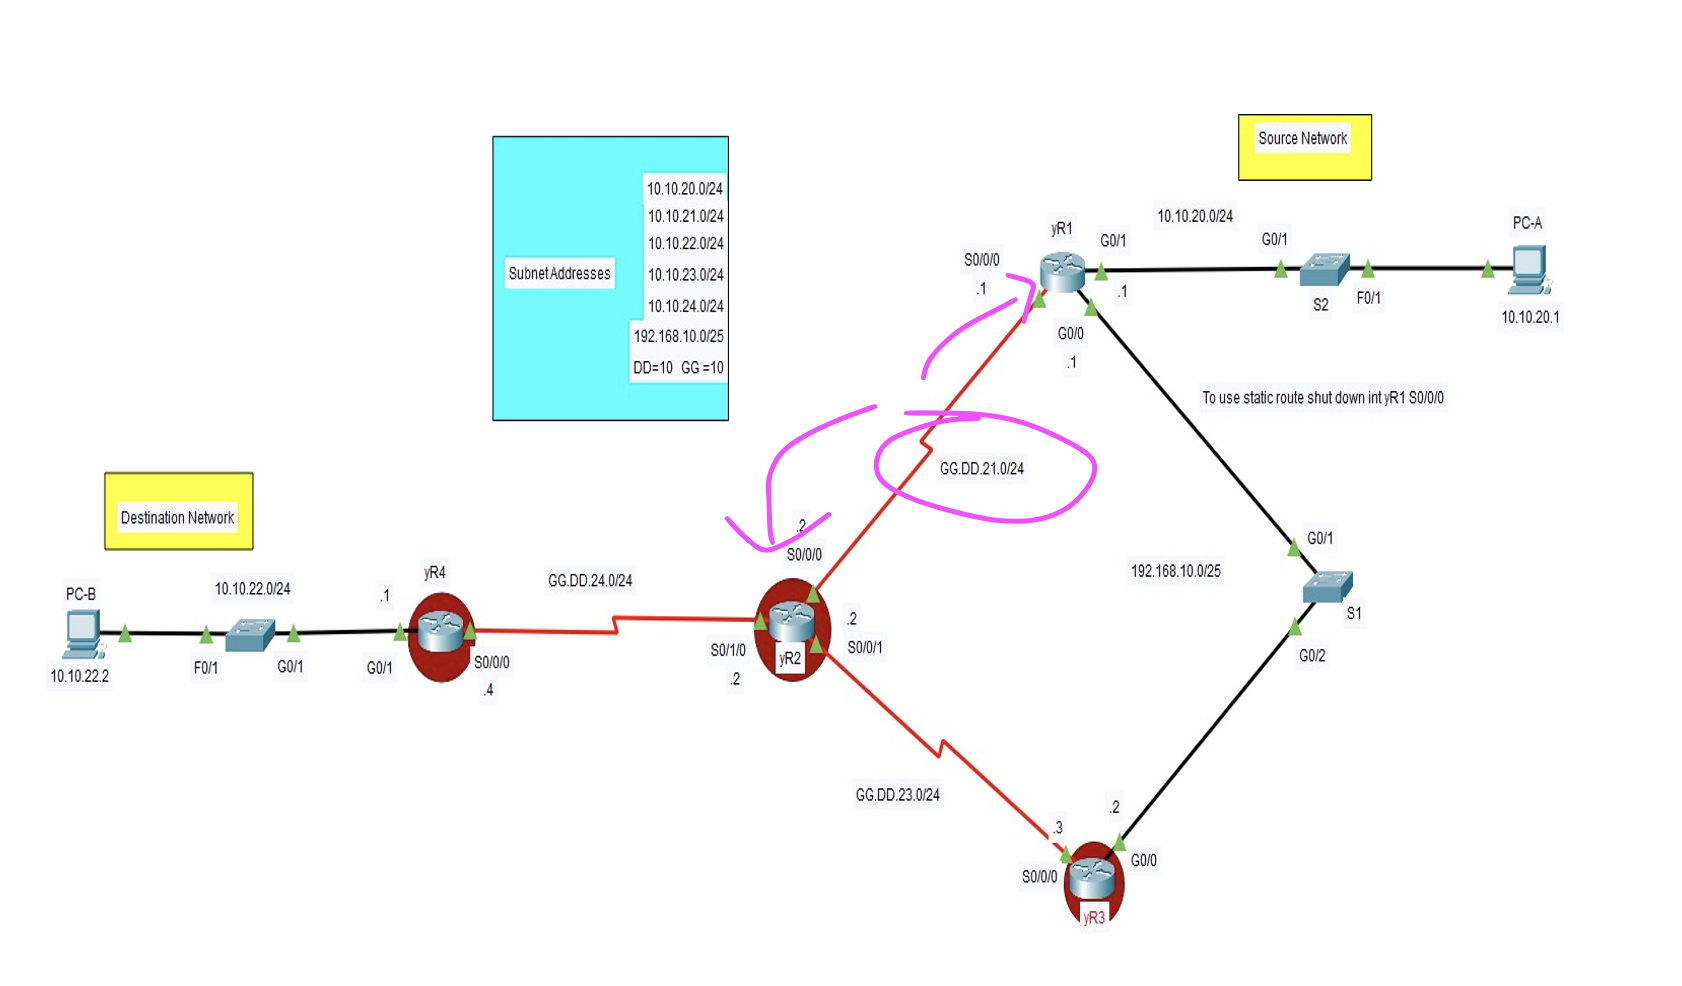

---

补充:

另外如上图, 想补充一下, 为路由器的每个接口以及pc配置好ip后, pc-B是不能ping通到pc-A的. 这是因为数据包的目的ip是`10.10.20.2`(图中搞错了, 电脑A和相连的路由器接口一个ip是不行的, 假设电脑ip是10.10.20.2), 数据包从电脑B到其默认网关yR4之后, yR4不知道`10.10.20.0`这个网络在哪, 它只知道`10.10.22.0`和`10.10.24.0`两个网络. 所以我们要知道他, 这时候yR4可以用RIP或者其他路由协议自动获取网络信息并同步到自己的路由表内, 也可以使用静态路由, 我们手动配置信息. 

这时候在yR4路由器上使用`ip route 10.10.20.0 255.255.255.0 10.10.24.2` 这个命令之后, 其路由表上就会多出一行信息, 也就是要去` 10.10.20.0`的数据包我都会转发到`10.10.24.2`也就是路由器yR2的s0/1/0接口. 之后需要在yR2路由器上添加`ip route 10.10.20.0 255.255.255.0 10.10.21.1` 然后这只是可以找到电脑A了,但是电脑A想回复的话, 数据包还不知道怎么回去, 这时候目的ip就成了电脑B的ip地址, 所以要在各个路由器上添加类似上面的命令, 比如对于路由器yR1, 我们要在其路由表添加这个信息: `ip route 10.10.22.0 255.255.255.0 10.10.21.2` 就是目的地址在网络`10.10.22.0`内的package, 需要转发到`10.10.21.2`, 也就是yR2的s0/0/0接口. 然后再以此类推...

```
// A类的前8位要求以0开始
A: 0000 0000 ~ 0111 1111 (decimal 0~127), subnet mask 255.0.0.0
// B类前8位要求从10开始
B: 1000 0000 ~ 1011 1111 (decimal 128~191) subnet mask 255.255.0.0
C: 1100 0000 ~ 1101 1111 (decimal 192~223) subnet mask 255.255.255.0
```